In [1]:
# Imports

from glob import glob
import os
import librosa
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sn
from sklearn.decomposition import PCA
import random

import sklearn.naive_bayes as nb
from sklearn.neural_network import MLPClassifier as mlp
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.tree import DecisionTreeClassifier as dec_tree

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn






In [2]:
### STEP 2 ###

loc = './pr_lab1_2020-21_data/digits'

'''
parse_free_digits(loc)
'''

def data_parser(directory):
    files = glob(os.path.join(directory, "*.wav"))
    fnames = [f.split('/')[3].split('.')[0] for f in files]
    # extract ids from filename
    ids = [int(f[-2]+f[-1]) if f[-2].isdigit() else int(f[-1]) for f in fnames]
    # extract float arrays of signals
    waves = [librosa.load(fpath,sr=None)[0] for fpath in files]
    # extract digits from filenames
    digits = []
    for i in range(len(fnames)):
        if str(ids[i]) in fnames[i]:
            fnames[i] = fnames[i].replace(str(ids[i]),'')
    
    return waves, ids, fnames


In [3]:
waves, ids, fnames = data_parser(loc)

print(f"{fnames[0]}{ids[0]} is a {type(waves[0])} with shape {waves[0].shape}")

seven5 is a <class 'numpy.ndarray'> with shape (13711,)


In [4]:
### STEP 3 ###

waves, _, _ = data_parser(loc)

def extract_mfcc(waves, num_mfcc=13, window=25, step=10):
    '''
    returns list of np.arrays of shape (frames of signal x num_mfcc)
    '''
    w = window*16 ## length of window in samples
    s = step*16  ## length of step in samples
    mfccs = [
        librosa.feature.mfcc(y=wav, n_mfcc=num_mfcc, n_fft=w, hop_length=s).T ## by default returns (MFCC x Frames) shape
        for wav in tqdm(waves, desc='Extracting MFCC features...')
    ]
    deltas = [librosa.feature.delta(mfcc) for mfcc in mfccs]
    ddeltas = [librosa.feature.delta(d) for d in deltas]
    
    print(f'Feature extraction completed: {num_mfcc} MFCCs per frame.')
    return mfccs, deltas, ddeltas


def extract_mfsc(waves, num_mfsc=13, window=25, step=10):
    '''
    returns list of np.arrays of shape (frames of signal x num_mfsc)
    '''
    w = window*16 ## length of window in samples
    s = step*16  ## length of step in samples
    mfscs = [
        librosa.feature.melspectrogram(y=wav, n_mels=num_mfsc, n_fft=w, hop_length=s).T ## by default returns (MFSC x Frames) shape
        for wav in tqdm(waves, desc='Extracting MFSC features...')
    ]
    
    print(f'Feature extraction completed: {num_mfsc} MFSCs per frame.')
    return mfscs



In [5]:
mfccs, deltas, ddeltas = extract_mfcc(waves)

print(f"{fnames[0]}{ids[0]} has {mfccs[0].shape[0]} frames of {mfccs[0].shape[1]} MFCCs")

print(f"Derivatives have a shape of {deltas[0].shape}")

mfscs = extract_mfsc(waves)

print(f"{fnames[0]}{ids[0]} has {mfscs[0].shape[0]} frames of {mfscs[0].shape[1]} MFSCs")


Extracting MFCC features...:   0%|                                                                                                                                                 | 0/133 [00:00<?, ?it/s]/home/tilemahos/.local/lib/python3.8/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
Extracting MFCC features...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:01<00:00, 69.51it/s]


Feature extraction completed: 13 MFCCs per frame.
seven5 has 86 frames of 13 MFCCs
Derivatives have a shape of (86, 13)


Extracting MFSC features...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 476.15it/s]

Feature extraction completed: 13 MFSCs per frame.
seven5 has 86 frames of 13 MFSCs


Extracting MFCC features...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:01<00:00, 73.21it/s]


Feature extraction completed: 13 MFCCs per frame.


Extracting MFSC features...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 547.99it/s]


Feature extraction completed: 13 MFSCs per frame.


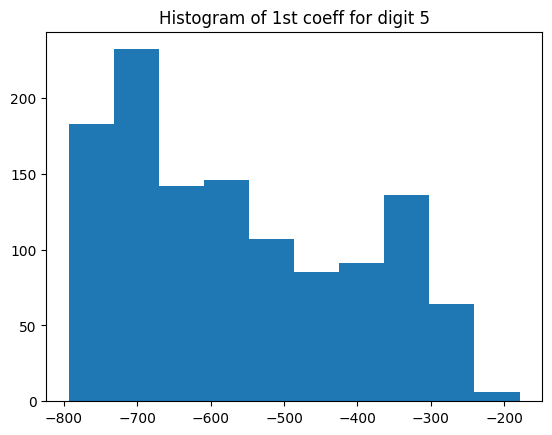

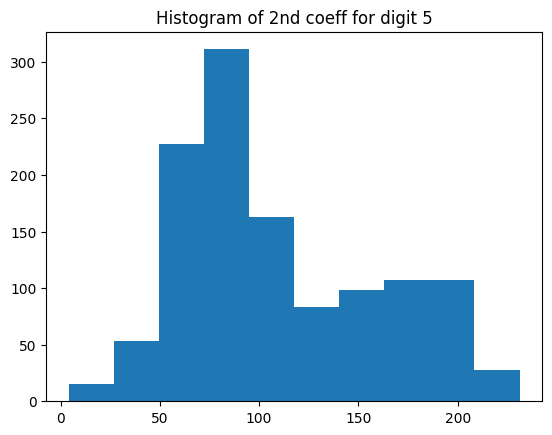

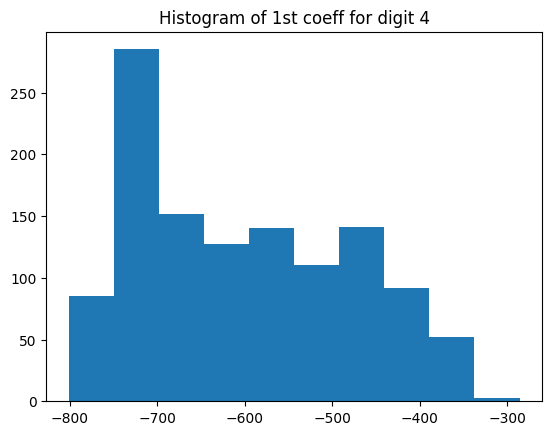

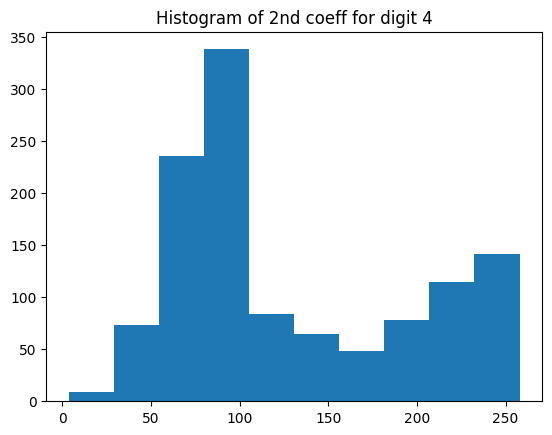

(1192,)


In [6]:
### STEP 4 ### 

loc = './pr_lab1_2020-21_data/digits'

n1 = 5 # Damianos
n2 = 4 # Aravanis

ston = {'zero':0, 'one':1, 'two':2, 'three':3, 'four':4, 'five':5, 'six':6, 'seven':7, 'eight':8, 'nine':9}

waves, ids, digits = data_parser(loc)
mfccs, deltas, ddeltas = extract_mfcc(waves)

digits = [ston[d] for d in digits]

mfscs = extract_mfsc(waves)

def find_indices(lista,item):
    indices = []
    for idx, value in enumerate(lista):
        if value == item:
            indices.append(idx)
    return indices

def digitsHistogram(n1,n2,mfccs,digits):
    ### find first 2 MFCCs of n1 digit for all speakers
    n1_indeces = find_indices(digits,n1)
    n1_feats0 = np.array([])
    n1_feats1 = np.array([])
    for i in n1_indeces:
        n1_feats0 = np.concatenate((n1_feats0,mfccs[i][:,0]),axis=0)
        n1_feats1 = np.concatenate((n1_feats1,mfccs[i][:,1]),axis=0)
    
    ### find first 2 MFCCs of n2 digit for all speakers
    n2_indeces = find_indices(digits,n2)
    n2_feats0 = np.array([])
    n2_feats1 = np.array([])
    for i in n2_indeces:
        n2_feats0 = np.concatenate((n2_feats0,mfccs[i][:,0]),axis=0)
        n2_feats1 = np.concatenate((n2_feats1,mfccs[i][:,1]),axis=0)
    
    plt.hist(n1_feats0)
    plt.title(f'Histogram of 1st coeff for digit {n1}')
    plt.show()
    plt.hist(n1_feats1)
    plt.title(f'Histogram of 2nd coeff for digit {n1}')
    plt.show()
    plt.hist(n2_feats0)
    plt.title(f'Histogram of 1st coeff for digit {n2}')
    plt.show()
    plt.hist(n2_feats1)
    plt.title(f'Histogram of 2nd coeff for digit {n2}')
    plt.show()
    
    print(n1_feats1.shape)
    
digitsHistogram(n1,n2,mfccs,digits)

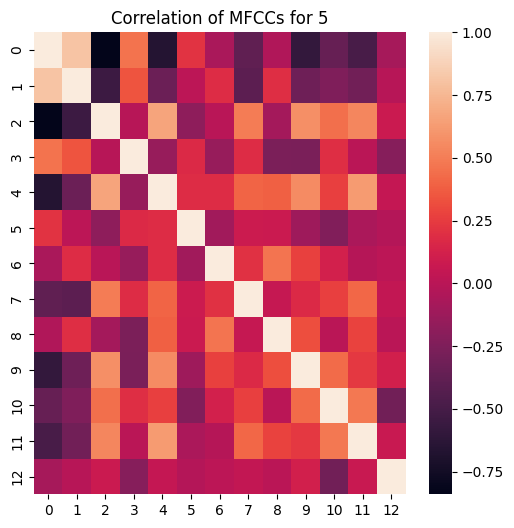

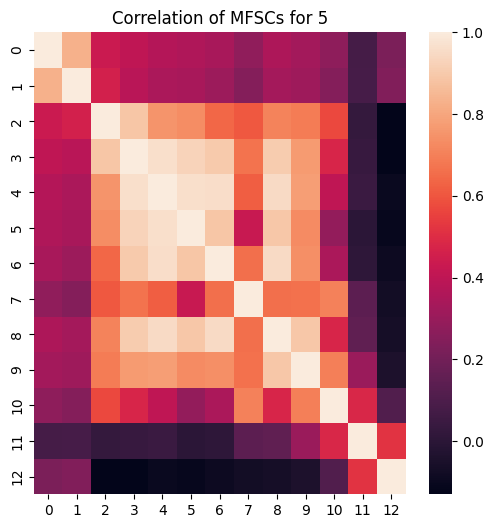

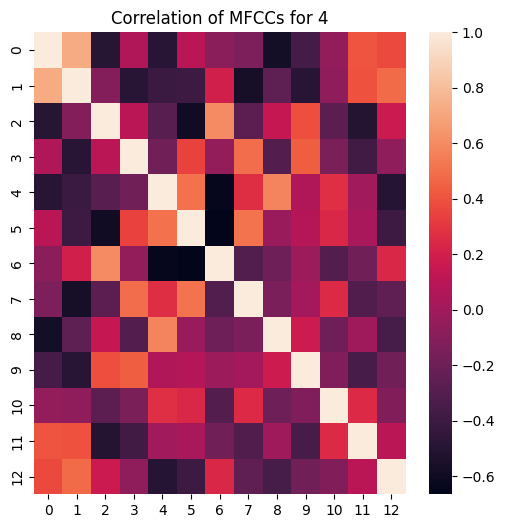

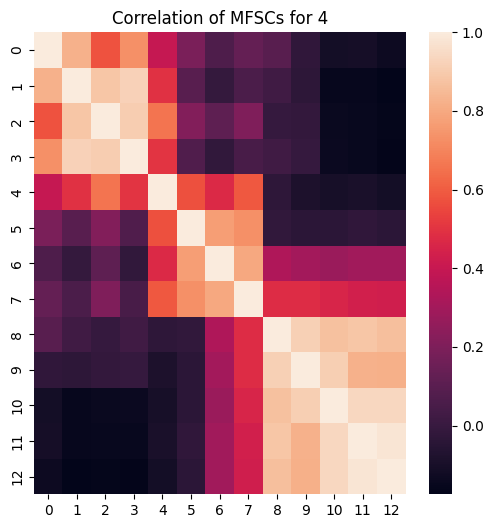

In [7]:
# Find two transcriptions for n1

i = 0
two_n1 = []
for idx, value in enumerate(digits):
    if value == n1:
        two_n1.append(idx)
        i +=1
        if i == 2:
            break

corr_matrix = np.corrcoef(np.concatenate((mfccs[two_n1[0]],mfccs[two_n1[1]]), axis=0).T)
fig, ax = plt.subplots(figsize=(6,6))
sn.heatmap(corr_matrix, ax=ax)
plt.title(f"Correlation of MFCCs for {n1}")
plt.show()

corr_matrix = np.corrcoef(np.concatenate((mfscs[two_n1[0]],mfscs[two_n1[1]]), axis=0).T)
fig, ax = plt.subplots(figsize=(6,6))
sn.heatmap(corr_matrix, ax=ax)
plt.title(f"Correlation of MFSCs for {n1}")
plt.show()
        
# Find two transcriptions for n2

i = 0
two_n2 = []
for idx, value in enumerate(digits):
    if value == n2:
        two_n2.append(idx)
        i +=1
        if i == 2:
            break

corr_matrix = np.corrcoef(np.concatenate((mfccs[two_n2[0]],mfccs[two_n2[1]]), axis=0).T)
fig, ax = plt.subplots(figsize=(6,6))
sn.heatmap(corr_matrix, ax=ax)
plt.title(f"Correlation of MFCCs for {n2}")
plt.show()  

corr_matrix = np.corrcoef(np.concatenate((mfscs[two_n2[0]],mfscs[two_n2[1]]), axis=0).T)
fig, ax = plt.subplots(figsize=(6,6))
sn.heatmap(corr_matrix, ax=ax)
plt.title(f"Correlation of MFSCs for {n2}")
plt.show()


In [8]:
### STEP 5 ###

features = [np.concatenate((mfccs[i],deltas[i],ddeltas[i]), axis=1) for i in range(len(mfccs))]
features[0].shape

(86, 39)

(78,)


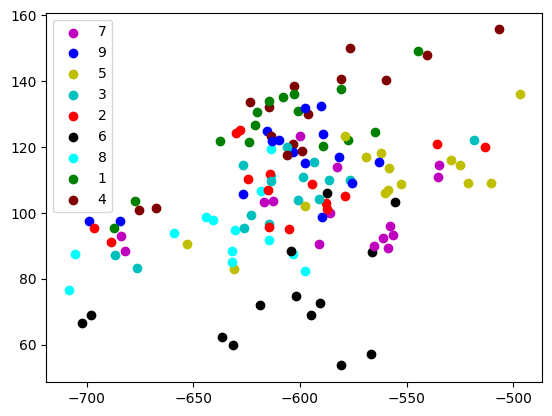

In [9]:
def legend_without_duplicate_labels(figure):
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    figure.legend(by_label.values(), by_label.keys(), loc='upper left')


feature_vectors = [np.concatenate((np.mean(features[i], axis=0),np.std(features[i], axis=0))) 
                  for i in range(len(features))]

print(feature_vectors[0].shape)

ntoc = {1:'g', 2:'r', 3:'c', 4:'maroon', 5:'y',
        6:'k', 7:'m', 8:'aqua', 9:'b'}

for idx, vec in enumerate(feature_vectors):
    x = vec[0]
    y = vec[1]
    plt.scatter(x,y,color=ntoc[digits[idx]],label=digits[idx])
    
legend_without_duplicate_labels(plt)
plt.show()
        

(133, 78)
The variance of the two components : [0.61310875 0.10540762]


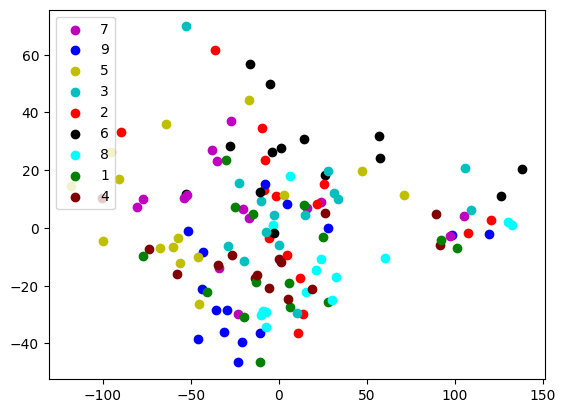

(133, 3)
The variance of the three components : [0.61310875 0.10540762 0.10259704]


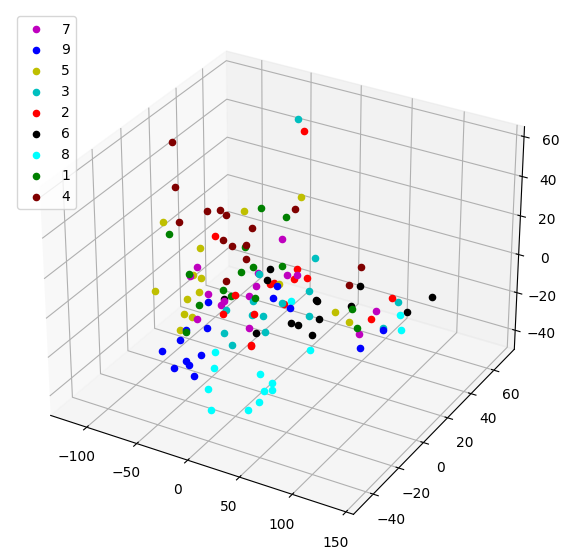

In [10]:
### STEP 6 ### 
data = np.asarray(feature_vectors)
print(data.shape)

pca_2 = PCA(n_components=2)
pca_3 = PCA(n_components=3)

# Two dim PCA

two_dim = pca_2.fit_transform(data)

print(f"The variance of the two components : {pca_2.explained_variance_ratio_}")

for idx, vec in enumerate(two_dim):
    x = vec[0]
    y = vec[1]
    plt.scatter(x,y,color=ntoc[digits[idx]],label=digits[idx])
    
legend_without_duplicate_labels(plt)
plt.show()

# Three dim PCA

three_dim = pca_3.fit_transform(data)
print(three_dim.shape)

print(f"The variance of the three components : {pca_3.explained_variance_ratio_}")

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
    
for idx, vec in enumerate(three_dim):
    x = vec[0]
    y = vec[1]
    z = vec[2]
 
    ax.scatter3D(x, y, z, color=ntoc[digits[idx]],label=digits[idx])

    
legend_without_duplicate_labels(plt)
plt.show()
        

In [11]:
### STEP 7 ###
print(f'Modified features len: {len(feature_vectors)} ,each feature shape: {feature_vectors[0].shape}')
print(f'Digits len: {len(digits)}')

### modify data ###
def createMfccDataset(data,labels):
    '''
    Returns list of tuples: (label, feature vector with this label)
    
    Each feature vector is a row from a feature table in data.
    THE IDEA: each vector of each MFCC table is a feature vector that belongs to a certain class
    '''
    res = []
    for idx,vec in enumerate(data):
            res.append((labels[idx],vec))
    return res
    
def createFeatsDataset(data,labels):
    res = []
    for idx,vec in enumerate(data):
        res.append((labels[idx],normalize([vec])[0]))
    return res
    

def split_data(dataset,train_perc = 0.7, test_perc = 0.3):
    '''
    Input: dataset (list of tuples) , train percentage, test percentage
    Output: train data,train labels,test data, test labels
    '''
    if train_perc+test_perc != 1:
        print("ERROR:Train and test percantages must add to 1.")
        return
    
## select train_perc*all data random ids 
train_ids = random.sample(range(0,len(dataset)-1),int(train_perc*len(dataset)))
    
## split data according to random ids
x_train = [dataset[i][1] for i in train_ids]
y_train = [dataset[i][0] for i in train_ids]
    
x_test = [dataset[i][1] for i in range(len(dataset)-1) if i not in train_ids]
y_test = [dataset[i][0] for i in range(len(dataset)-1) if i not in train_ids]
    
return x_train, y_train, x_test, y_test
    
    

Modified features len: 133 ,each feature shape: (78,)
Digits len: 133


In [12]:
dataset = createMfccDataset(feature_vectors, digits)
X_train, Y_train, X_test, Y_test = split_data(dataset)

print(f'Percentages: train:{len(X_train)/len(dataset)}, test:{len(X_test)/len(dataset)}')
print(f'Data shape:{np.shape(X_train)}')
print(f'Labels shape:{np.shape(Y_train)}')


Percentages: train:0.6992481203007519, test:0.2932330827067669
Data shape:(93, 78)
Labels shape:(93,)


In [13]:
# Scale each feature to zero mean and unit var

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

print(X_train.shape)

(93, 78)


In [14]:
#### Model training ####

## 1st model: gaussian naive bayes model training and testing
gnb = nb.GaussianNB()
gnb.fit(X_train,Y_train)

gnb_predictions = gnb.predict(X_test)


    
## 2nd model: MLP
mlp_model = mlp(random_state=1, max_iter=1000)
mlp_model.fit(X_train, Y_train)

mlp_predictions = mlp_model.predict(X_test)


## 3rd model: k-nn
knn_model = knn(n_neighbors=13)
knn_model.fit(X_train,Y_train)

knn_predictions = knn_model.predict(X_test)


## 4th model: decision tree 
decTree_model = dec_tree()
decTree_model.fit(X_train, Y_train)

decTree_predictions = decTree_model.predict(X_test)


### Test the quality of predictions

## Check accuracy:
gnb_acc = accuracy_score(Y_test, gnb_predictions)
mlp_acc = accuracy_score(Y_test, mlp_predictions)
knn_acc = accuracy_score(Y_test, knn_predictions)
decTree_acc = accuracy_score(Y_test, decTree_predictions)

print(f"Naive Bayes acc: {gnb_acc}\nMLP acc: {mlp_acc} \nK-NN acc: {knn_acc} \nDecision Tree acc: {decTree_acc}")

Naive Bayes acc: 0.6410256410256411
MLP acc: 0.7435897435897436 
K-NN acc: 0.3333333333333333 
Decision Tree acc: 0.6410256410256411


In [15]:
### BONUS: Incorporate zcr as a feature

def zero_crossing_rate(audio_signal):
    # Initialize a variable to count zero crossings
    zero_crossings = 0

    # Iterate through the audio signal to count zero crossings
    for i in range(1, len(audio_signal)):
        if (audio_signal[i-1] >= 0 and audio_signal[i] < 0) or (audio_signal[i-1] < 0 and audio_signal[i] >= 0):
            zero_crossings += 1

    # Calculate the zero crossing rate
    zcr = zero_crossings / (2 * len(audio_signal))

    return zcr

zcrs = [zero_crossing_rate(audio) for audio in waves]

feature_vectors_with_zcr = [np.concatenate((feature_vectors[i], np.asarray([zcrs[i]]))) for i in range(len(feature_vectors))]

print(f'Modified features len: {len(feature_vectors_with_zcr)} ,each feature shape: {feature_vectors_with_zcr[0].shape}')


Modified features len: 133 ,each feature shape: (79,)


In [16]:
# Same as STEP 7 but with ZCR as a feature

dataset = createMfccDataset(feature_vectors_with_zcr, digits)
X_train, Y_train, X_test, Y_test = split_data(dataset)

print(f'Percentages: train:{len(X_train)/len(dataset)}, test:{len(X_test)/len(dataset)}')
print(f'Data shape:{np.shape(X_train)}')
print(f'Labels shape:{np.shape(Y_train)}\n')

# Scale each feature to zero mean and unit var

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#### Model training ####

gnb = nb.GaussianNB()
gnb.fit(X_train,Y_train)
gnb_predictions = gnb.predict(X_test)

mlp_model = mlp(random_state=1, max_iter=1000)
mlp_model.fit(X_train, Y_train)
mlp_predictions = mlp_model.predict(X_test)

knn_model = knn(n_neighbors=13)
knn_model.fit(X_train,Y_train)
knn_predictions = knn_model.predict(X_test)

decTree_model = dec_tree()
decTree_model.fit(X_train, Y_train)
decTree_predictions = decTree_model.predict(X_test)

## Check accuracy:
gnb_acc = accuracy_score(Y_test, gnb_predictions)
mlp_acc = accuracy_score(Y_test, mlp_predictions)
knn_acc = accuracy_score(Y_test, knn_predictions)
decTree_acc = accuracy_score(Y_test, decTree_predictions)

print(f"Naive Bayes acc: {gnb_acc}\nMLP acc: {mlp_acc} \nK-NN acc: {knn_acc} \nDecision Tree acc: {decTree_acc}")


Percentages: train:0.6992481203007519, test:0.2932330827067669
Data shape:(93, 79)
Labels shape:(93,)

Naive Bayes acc: 0.5128205128205128
MLP acc: 0.7692307692307693 
K-NN acc: 0.46153846153846156 
Decision Tree acc: 0.48717948717948717


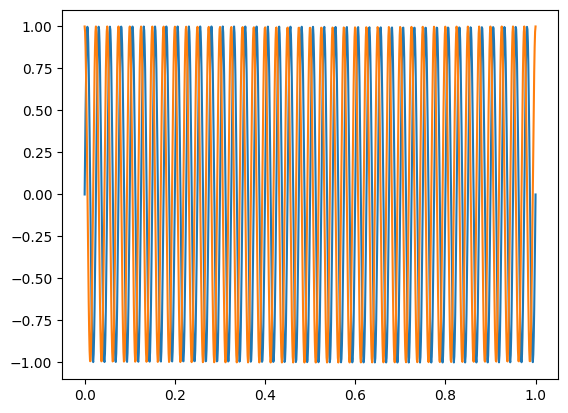

In [17]:
### STEP 8 ###

## create sin and cos sequences to sample from
freq = 40
points = 1000 ## points per time
max_t = 1
t = np.linspace(0,max_t,max_t*points)
sin_t = np.sin(2*np.pi*freq*t)
cos_t = np.cos(2*np.pi*freq*t)
plt.plot(t,sin_t)
plt.plot(t,cos_t)
plt.show()


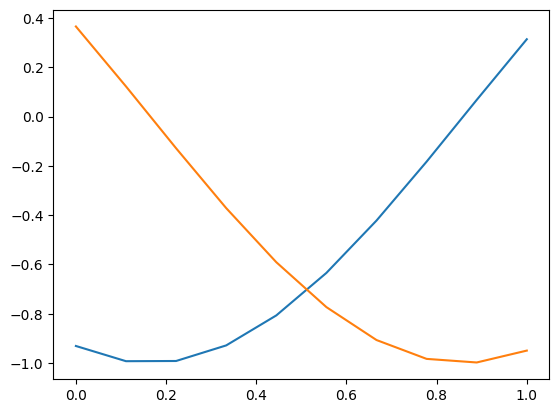

Input seq len:90, target seq len:90
Shape of each sample: sin:(10,), cos:(10,)


In [18]:
## divide sin and cos to sub-sequences
frame = 10
start = 0
sin_samp = []
cos_samp = []
while start+frame<len(sin_t):
    sin_samp.append(sin_t[start:start+frame])
    cos_samp.append(cos_t[start:start+frame])
    start += frame+1


plt.plot(np.linspace(0,1,(cos_samp[1]).shape[0]),cos_samp[1])
plt.plot(np.linspace(0,1,(sin_samp[1]).shape[0]),sin_samp[1])
plt.show()

print(f'Input seq len:{len(sin_samp)}, target seq len:{len(cos_samp)}')
print(f'Shape of each sample: sin:{sin_samp[0].shape}, cos:{cos_samp[0].shape}')

In [19]:
## models
class myRNN(nn.Module):
    def __init__(self,input_shape,hidden_size,output_size):
        super().__init__()
        self.input_shape = input_shape
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size=self.input_shape, hidden_size=self.hidden_size)
        self.linear = nn.Linear(self.hidden_size,self.output_size)
        
    def forward(self,x):
        h0 = torch.randn(1,self.hidden_size)
        out, _ = self.rnn(x,h0)
        ret = self.linear(out)
        return ret
    
class myLSTM(nn.Module):
    def __init__(self,input_shape,hidden_size,output_size):
        super().__init__()
        self.input_shape = input_shape
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTM(self.input_shape,hidden_size=self.hidden_size)
        self.linear = nn.Linear(self.hidden_size,self.output_size)
    
    def forward(self,x):
        h0 = torch.randn(1,self.hidden_size)
        c0 = torch.randn(1,self.hidden_size)
        out, _ = self.lstm(x,(h0,c0))
        ret = self.linear(out)
        return ret
    
class myGRU(nn.Module):
    def __init__(self,input_shape,hidden_size,output_size):
        super().__init__()
        self.input_shape = input_shape
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.gru = nn.GRU(input_size=self.input_shape, hidden_size=self.hidden_size)
        self.linear = nn.Linear(self.hidden_size,self.output_size)
        
    def forward(self,x):
        h0 = torch.randn(1,self.hidden_size)
        out, _ = self.gru(x,h0)
        ret = self.linear(out)
        return ret
        
        
        

In [20]:
### training function 
def training(epochs,
             dataset,
             model,
             loss_fn,
             optimizer):
    data = dataset[0]
    targets = dataset[1]
    losses = []
    seq_len = data.shape[0]
    
    model.train()
    print('Training ...')
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        loss = 0
        for X,Y in zip(data,targets):
            preds = model(X.unsqueeze(1))
            loss += loss_fn(preds,Y)
        losses.append(loss.data.item()/seq_len)
        loss.backward()
        optimizer.step()
    return losses

In [21]:
## data setup 
seq_len = len(sin_samp) ## 90
samp_size = sin_samp[0].shape[0] ## 10
print(seq_len, samp_size)

input = torch.from_numpy(np.asarray(sin_samp,dtype=np.float32))
target = torch.from_numpy(np.asarray(cos_samp,dtype=np.float32))


90 10


RNN training:
Training ...


  0%|                                                                                                                                                                              | 0/100 [00:00<?, ?it/s]/home/tilemahos/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.76it/s]



LSTM training:
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.99it/s]



GRU training:
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.47it/s]


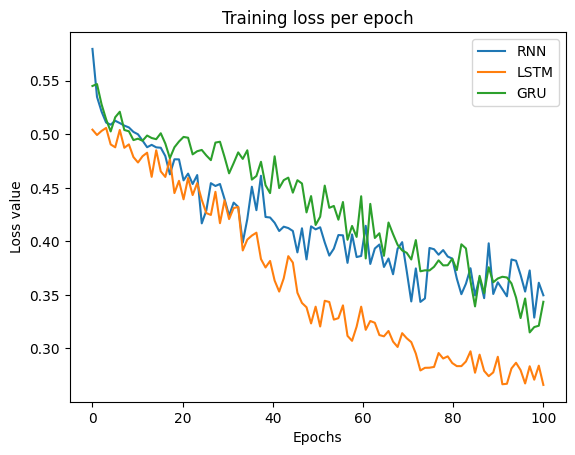

In [22]:
## Initiate and train models
dataset = (input,target)

rnn_model = myRNN(input_shape=1,hidden_size=10,output_size=1)
lstm_model = myLSTM(input_shape=1,hidden_size=10,output_size=1)
gru_model = myGRU(input_shape=1,hidden_size=10,output_size=1)

print('RNN training:')
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=rnn_model.parameters(), lr=1e-2)
EPOCHS = 100
rnn_losses = training(epochs=EPOCHS,dataset=dataset,model=rnn_model,loss_fn=loss_fn,optimizer=optimizer)

print('\nLSTM training:')
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=lstm_model.parameters(), lr=1e-2)
lstm_losses = training(epochs=EPOCHS,dataset=dataset,model=lstm_model,loss_fn=loss_fn,optimizer=optimizer)

print('\nGRU training:')
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=gru_model.parameters(), lr=1e-2)
gru_losses = training(epochs=EPOCHS,dataset=dataset,model=gru_model,loss_fn=loss_fn,optimizer=optimizer)



plt.figure()
plt.plot(np.linspace(0,EPOCHS,EPOCHS),rnn_losses)
plt.plot(np.linspace(0,EPOCHS,EPOCHS),lstm_losses)
plt.plot(np.linspace(0,EPOCHS,EPOCHS),gru_losses)
plt.title('Training loss per epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend(['RNN', "LSTM","GRU"])
